In [1]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

import seaborn as sns
import pandas as pd

# fetch dataset 
steel_plates_faults = fetch_ucirepo(id=198) 
  
# data (as pandas dataframes) 
X = steel_plates_faults.data.features 
y = steel_plates_faults.data.targets


#the values for each are at around 950 entries each, so this data distribution is balanced
#along with the pasty, stains, dirtiness, otherfaults  are minor flaws which can be cleaned
y_nonDefect = steel_plates_faults.data.targets[["Pastry", "Stains", "Dirtiness", "Other_Faults"]]
y_Defect = steel_plates_faults.data.targets[["Z_Scratch", "K_Scratch", "Bumps"]]


#check for NaN:
check_NaN_features = steel_plates_faults.data.features.isnull().sum().any()
check_NaN_targets = steel_plates_faults.data.targets.isnull().sum().any()
print("Any NaN within Dataset:",check_NaN_features, check_NaN_targets)

y.value_counts()

Any NaN within Dataset: False False


Pastry  Z_Scratch  K_Scratch  Stains  Dirtiness  Bumps  Other_Faults
0       0          0          0       0          0      1               673
                                                 1      0               402
                   1          0       0          0      0               391
        1          0          0       0          0      0               190
1       0          0          0       0          0      0               158
0       0          0          1       0          0      0                72
                              0       1          0      0                55
Name: count, dtype: int64

In [2]:
#change into binary
#define nondefective faults
nondefect_faults = ["Pastry", "Stains", "Dirtiness", "Other_Faults"]

# All fault columns in dataset
all_fault_cols = list(y.columns)

# faults that will be labeled 1 (defects)
defect_faults = [col for col in all_fault_cols if col not in nondefect_faults]

# Create binary label:
# 1 if the plate has any defect_faults
# 0 if the plate has only nondefect faults
y = ((y[defect_faults].sum(axis=1) > 0).astype(int))

#it should be balanced when using Random forest

y.value_counts(normalize=True)


1    0.50644
0    0.49356
Name: proportion, dtype: float64

In [3]:
#split data into training 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
#grid search for finding best hyperparameters
from sklearn.model_selection import GridSearchCV

parameter_grid = {
    'n_estimators' : [180,200,220],
    'min_samples_split' : [4,5,6],
    'min_samples_leaf' : [1,2],
    'max_features' : [4,5,6],
    'bootstrap' : [True,False],
    'random_state' : [42]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=parameter_grid, cv=5)
grid_search.fit(X_train, y_train)
#print best parameters
print(grid_search.best_params_)
gs = grid_search.best_estimator_


{'bootstrap': False, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 180, 'random_state': 42}


In [5]:
#### Comparison of decision tree, random forest (trial and error tuned), Random forest (grid search)
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
print("Single decision tree accuracy:" + str(round(accuracy_score(y_test, dt_pred),4)))

# Random Forest (with bagging)
rf_full = RandomForestClassifier(n_estimators=200, random_state=42, min_samples_split=5, max_features=5, bootstrap=True)
rf_full.fit(X_train, y_train)
rf_full_pred = rf_full.predict(X_test)
print("Random Forest Accuracy:" + str(round(accuracy_score(y_test, rf_full_pred),4)))

#grid serach
gs_pred = gs.predict(X_test)
print("Random Forest (grid search) Accuracy:" + str(round(accuracy_score(y_test, gs_pred),4)))

Single decision tree accuracy:0.8072
Random Forest Accuracy:0.8458
Random Forest (grid search) Accuracy:0.8329



Accuracy: 0.8277634961439588

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       192
           1       0.83      0.83      0.83       197

    accuracy                           0.83       389
   macro avg       0.83      0.83      0.83       389
weighted avg       0.83      0.83      0.83       389



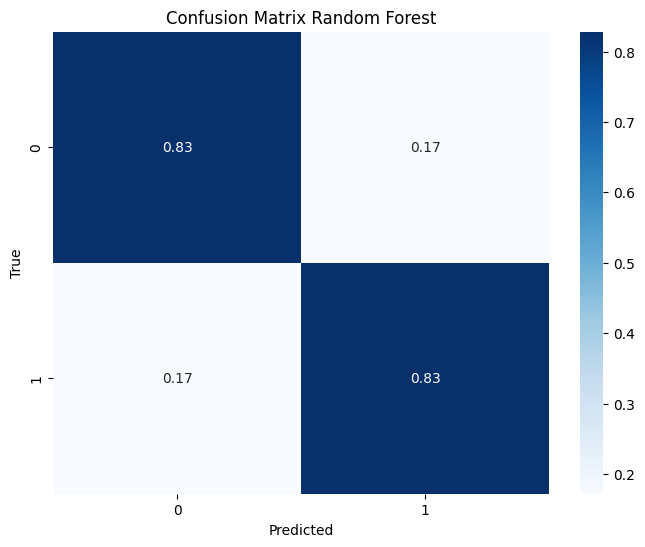

In [14]:
#y prediction for confusion matrix
y_pred = rf_full.predict(X_test)
#validation of model using normalized confusion matrix, and accuracy
cm = confusion_matrix(y_test, y_pred,normalize="true")
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues",
            xticklabels=rf_full.classes_,
            yticklabels=rf_full.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Random Forest")
plt.savefig("CM_binary/CM_rf")
plt.show()


Accuracy: 0.8226221079691517

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       192
           1       0.83      0.81      0.82       197

    accuracy                           0.82       389
   macro avg       0.82      0.82      0.82       389
weighted avg       0.82      0.82      0.82       389



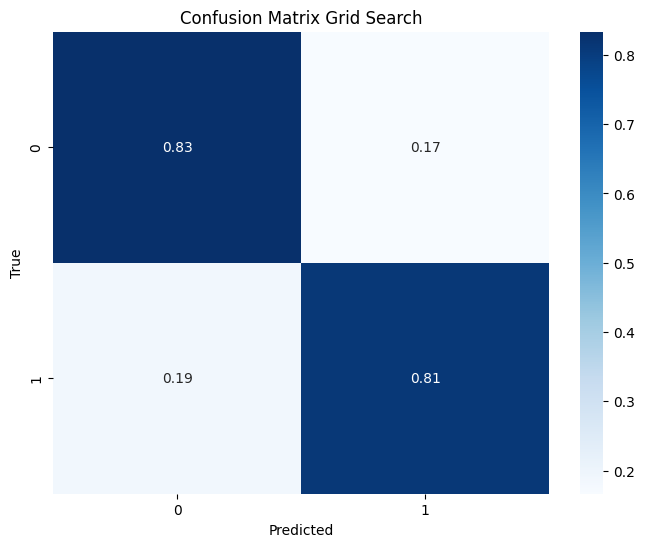

In [15]:
#y prediction for confusion matrix
y_pred = gs.predict(X_test)
#validation of model using normalized confusion matrix, and accuracy
cm = confusion_matrix(y_test, y_pred,normalize="true")
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues",
            xticklabels=gs.classes_,
            yticklabels=gs.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Grid Search")
plt.savefig("CM_binary/CM_gs")
plt.show()

In [8]:
#feature importance.
for score, name in zip(rf_full.feature_importances_, X):
    print(round(score, 3), name)

0.045 X_Minimum
0.043 X_Maximum
0.035 Y_Minimum
0.034 Y_Maximum
0.051 Pixels_Areas
0.034 X_Perimeter
0.02 Y_Perimeter
0.048 Sum_of_Luminosity
0.029 Maximum_of_Luminosity
0.047 Length_of_Conveyer
0.035 TypeOfSteel_A300
0.038 TypeOfSteel_A400
0.066 Steel_Plate_Thickness
0.035 Edges_Index
0.028 Empty_Index
0.049 Square_Index
0.039 Outside_X_Index
0.026 Edges_X_Index
0.024 Edges_Y_Index
0.003 Outside_Global_Index
0.065 LogOfAreas
0.042 Log_X_Index
0.03 Log_Y_Index
0.045 Orientation_Index
0.034 Luminosity_Index
0.024 SigmoidOfAreas
0.031 Minimum_of_Luminosity


In [9]:
#FEATURE IMPORTANCE TEST BELOW
#
#
#
#
#
#
#

In [18]:
# Reloading data set for feature importance test
steel_plates_faults = fetch_ucirepo(id=198)

X = steel_plates_faults.data.features
y = steel_plates_faults.data.targets

#change into binary
#define nondefects
nondefect_faults = ["Pastry", "Stains", "Dirtiness", "Other_Faults"]

# All fault columns in dataset
all_fault_cols = list(y.columns)

# Faults that will be labeled 1 (defects)
defect_faults = [col for col in all_fault_cols if col not in nondefect_faults]

#convert binary
y = ((y[defect_faults].sum(axis=1) > 0).astype(int))

#train random forest to test for feature importance
rf = RandomForestClassifier(n_estimators=200, random_state=42, min_samples_split=5, max_features=5, bootstrap=False)
rf.fit(X, y)
#compute feature importance
feat_imp = pd.Series(rf.feature_importances_, index=X.columns)
feat_imp = feat_imp.sort_values(ascending=False)

#K controls the amount of top features used
K = 15

#print feature importance
print("\nTop " +str(K)+ " features:")
print(feat_imp.head(K))

#saves the top features
top_features = feat_imp.head(K).index.tolist()

#reduced X to match the size for new top features
X_reduced = X[top_features]

print("\nReduced feature shape:", X_reduced.shape)

# Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y
)



Top 15 features:
Steel_Plate_Thickness    0.081364
LogOfAreas               0.060579
Square_Index             0.055147
Log_X_Index              0.054109
Length_of_Conveyer       0.049821
Pixels_Areas             0.049512
X_Minimum                0.047527
Orientation_Index        0.043880
Sum_of_Luminosity        0.043481
X_Maximum                0.040165
Outside_X_Index          0.038580
TypeOfSteel_A400         0.036202
TypeOfSteel_A300         0.034531
Y_Maximum                0.034280
Y_Minimum                0.032907
dtype: float64

Reduced feature shape: (1941, 15)


In [19]:
# Random Forest (with bagging)
rf_full = RandomForestClassifier(n_estimators=200, random_state=42, min_samples_split=5, max_features=5, bootstrap=False)
rf_full.fit(X_train, y_train)
rf_full_pred = rf_full.predict(X_test)

gs.fit(X_train, y_train)
gs_pred = gs.predict(X_test)
print("Random Forest Accuracy:" + str(round(accuracy_score(y_test, rf_full_pred),4)))
print("Grid Search Accuracy:" + str(round(accuracy_score(y_test, gs_pred),4)))

Random Forest Accuracy:0.8098
Grid Search Accuracy:0.8149



Accuracy: 0.8097686375321337

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       192
           1       0.82      0.81      0.81       197

    accuracy                           0.81       389
   macro avg       0.81      0.81      0.81       389
weighted avg       0.81      0.81      0.81       389



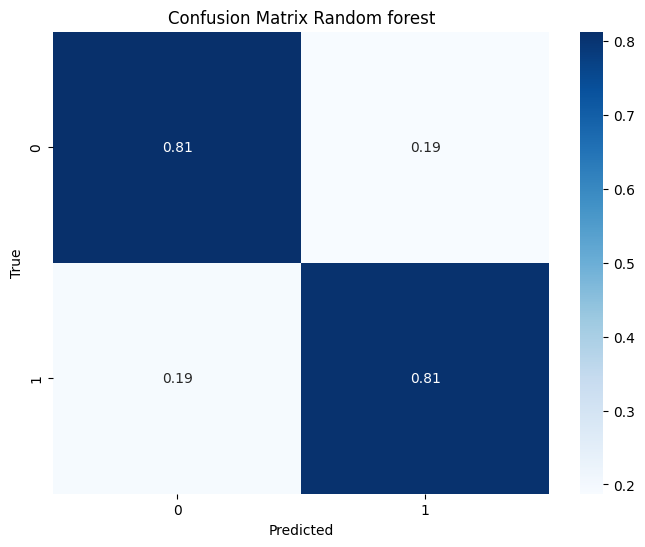

In [20]:
#saves a prediction of y for use in confusion matrix
y_pred = rf_full.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#normalized confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize="true")

#plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues",
            xticklabels=rf_full.classes_,
            yticklabels=rf_full.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Random forest")
plt.savefig("CM_binary/CM_rf_feature")
plt.show()


Accuracy: 0.8149100257069408

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       192
           1       0.82      0.81      0.82       197

    accuracy                           0.81       389
   macro avg       0.81      0.82      0.81       389
weighted avg       0.82      0.81      0.81       389



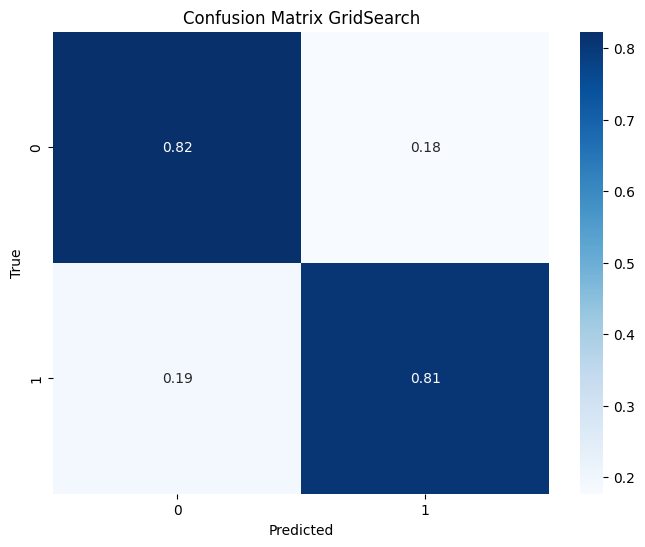

In [21]:
#saves a prediction of y for use in confusion matrix
y_pred = gs.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#normalized confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize="true")

#plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues",
            xticklabels=gs.classes_,
            yticklabels=gs.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix GridSearch")
plt.savefig("CM_binary/CM_gs_feature")
plt.show()